## Import data and visualization

In [1]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi

DATA_FOLDER = "Data"
NUMBER_OF_ELEMENTS = 6


def load_data():
    lungs = []
    vessels = []
    vol = []
    for i in range(1, NUMBER_OF_ELEMENTS + 1):
        lungs.append(
            sitk.GetArrayFromImage(sitk.ReadImage(f"{DATA_FOLDER}/lungs_0{i}.nii.gz"))
        )
        vessels.append(
            sitk.GetArrayFromImage(sitk.ReadImage(f"{DATA_FOLDER}/vessels_0{i}.nii.gz"))
        )
        vol.append(
            sitk.GetArrayFromImage(sitk.ReadImage(f"{DATA_FOLDER}/vol_0{i}.nii.gz"))
        )

    return lungs, vessels, vol


def plot_slices(tensor, max_images=20, n_columns=5, figsize=(5, 5), title=None):
    indexes = np.linspace(0, tensor.shape[0] - 1, max_images).astype(int)

    n_rows = (len(indexes) - 1) // n_columns + 1

    fig, axes = plt.subplots(n_rows, n_columns, figsize=figsize)

    for i, index in enumerate(indexes):
        ax = axes.flatten()[i]
        ax.imshow(tensor[index], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    if title:
        fig.suptitle(
            title, fontsize=16, y=1.02
        )  # y adjusts the vertical position of the title

    plt.show()


def plot_multiple_slices(
    *tensors, max_images=5, labels=None, n_columns=5, figsize=(5, 5)
):
    if labels is None:
        labels = [f"Tensor {i}" for i in range(len(tensors))]
    assert len(tensors) == len(labels)

    slices_indexes = np.linspace(0, tensors[0].shape[0] - 1, max_images).astype(int)

    n_rows = (len(slices_indexes) - 1) // n_columns + 1

    n_images_per_group = len(tensors)

    fig, axes = plt.subplots(n_rows * n_images_per_group, n_columns, figsize=figsize)

    for i, slices_index in enumerate(slices_indexes):
        for j, tensor in enumerate(tensors):
            row = i // n_columns
            column = i % n_columns
            ax = axes[row * n_images_per_group + j, column]
            ax.imshow(tensor[slices_index], cmap="gray")
            ax.axis("off")
            ax.set_title(f"{labels[j]} at slice {slices_index}")

    # plt.tight_layout()
    plt.show()


def normalize_image(image):
    max_value, min_value = np.max(image), np.min(image)
    image = (image - min_value) / (max_value - min_value)

    return image


def remove_background(image, keep_mask):
    min_value_inside_lungs = np.min(image[keep_mask == 1])
    image[keep_mask == 0] = min_value_inside_lungs

    return image


def process_image(image, keep_mask):
    image = remove_background(image, keep_mask)
    image = normalize_image(image)

    return image


lungs, vessels, vol = load_data()

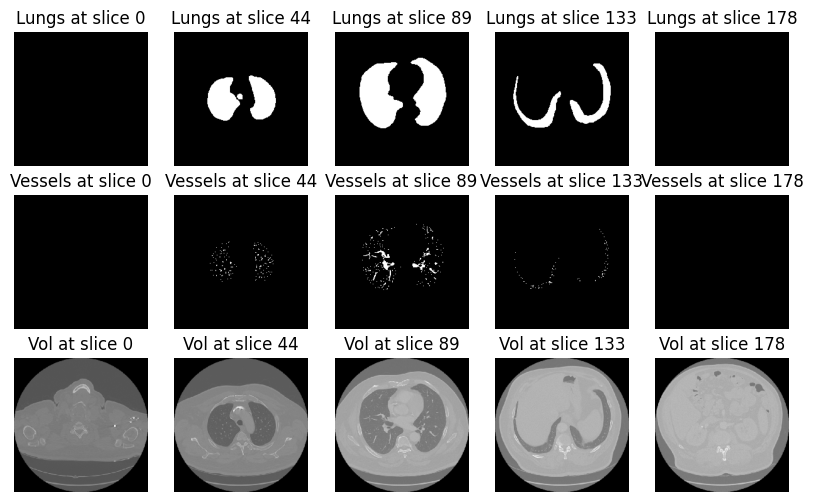

In [2]:
# Visualize data samples
plot_multiple_slices(
    lungs[0],
    vessels[0],
    vol[0],
    labels=["Lungs", "Vessels", "Vol"],
    max_images=5,
    n_columns=5,
    figsize=(10, 6),
)

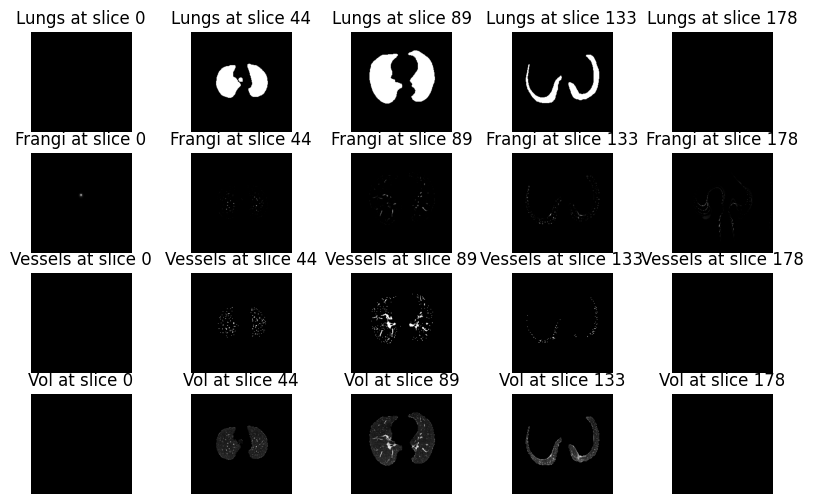

In [3]:
# visualization of Frangi vesselness filter

frangi_seg = frangi(
    process_image(vol[0], lungs[0]),
    sigmas=range(1, 20, 2),  # range(1, 20, 2),
    scale_range=None,
    scale_step=None,
    alpha=0.5,
    beta=0.5,
    gamma=None,
    black_ridges=False,
    mode="reflect",
    cval=0,
)

plot_multiple_slices(
    lungs[0],
    frangi_seg,
    vessels[0],
    vol[0],
    labels=["Lungs", "Frangi", "Vessels", "Vol"],
    max_images=5,
    n_columns=5,
    figsize=(10, 6),
)

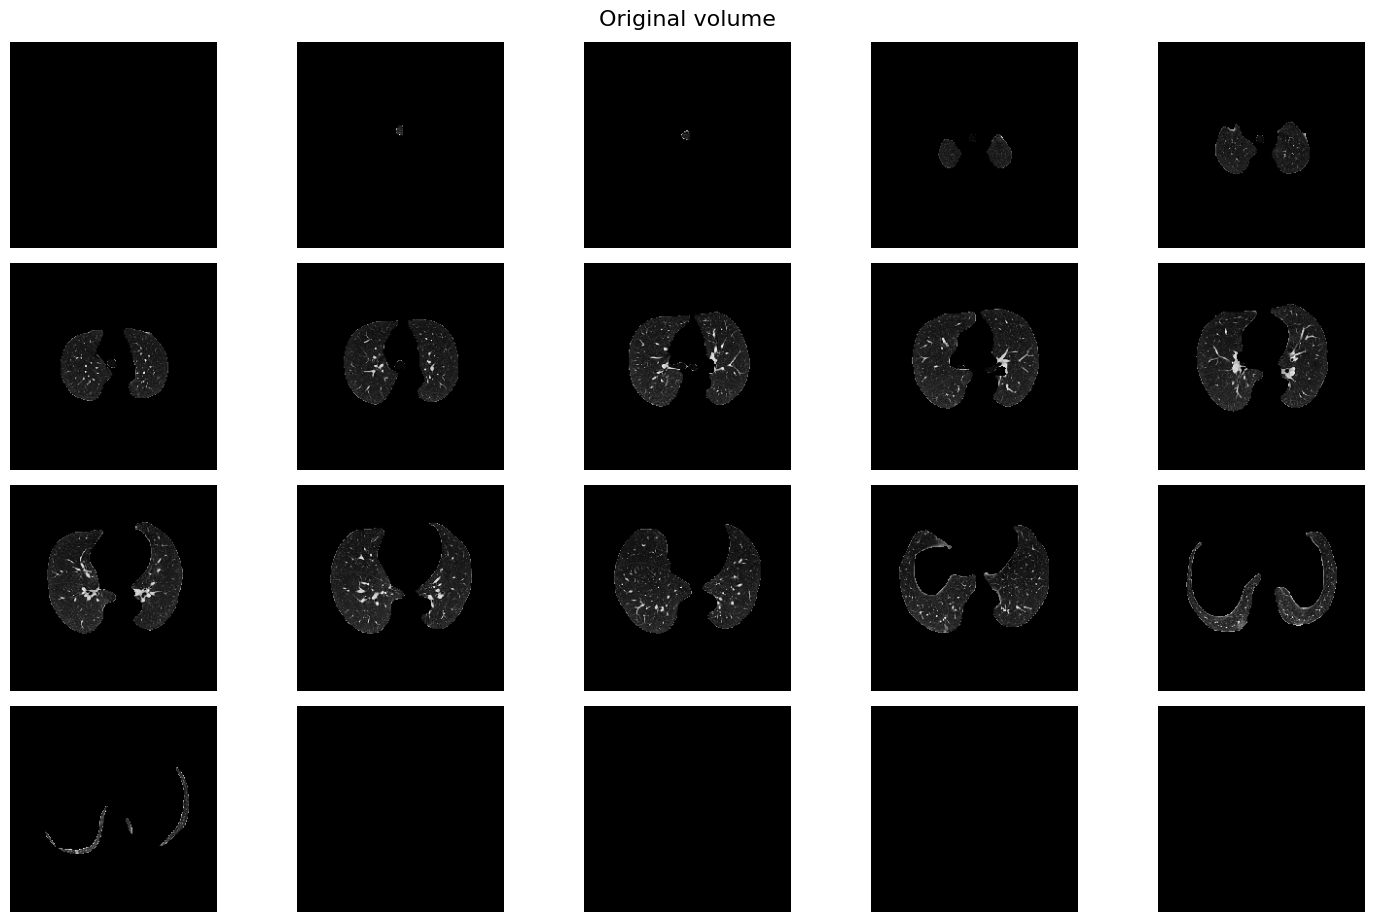

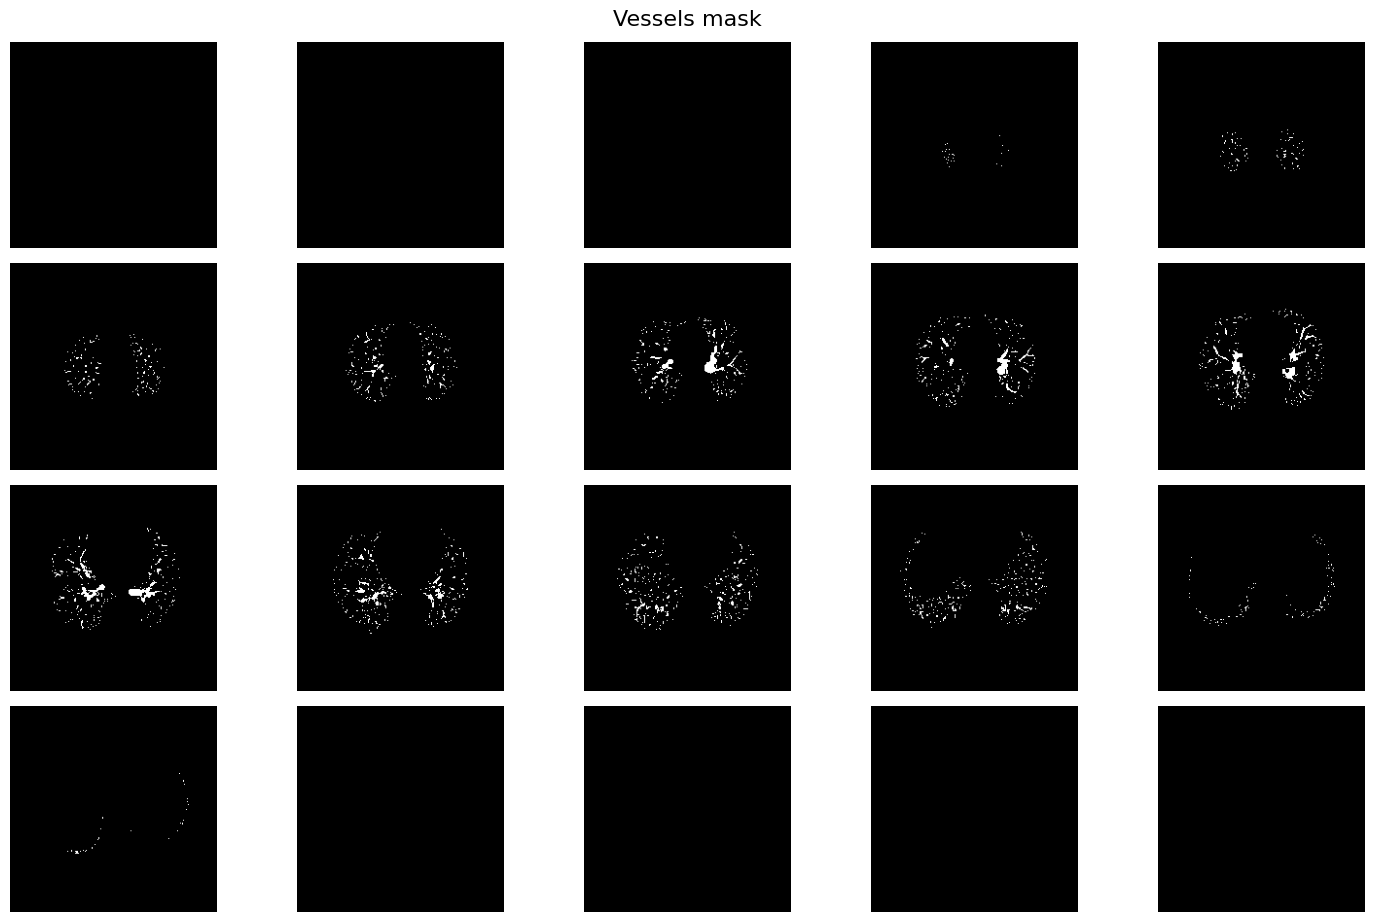

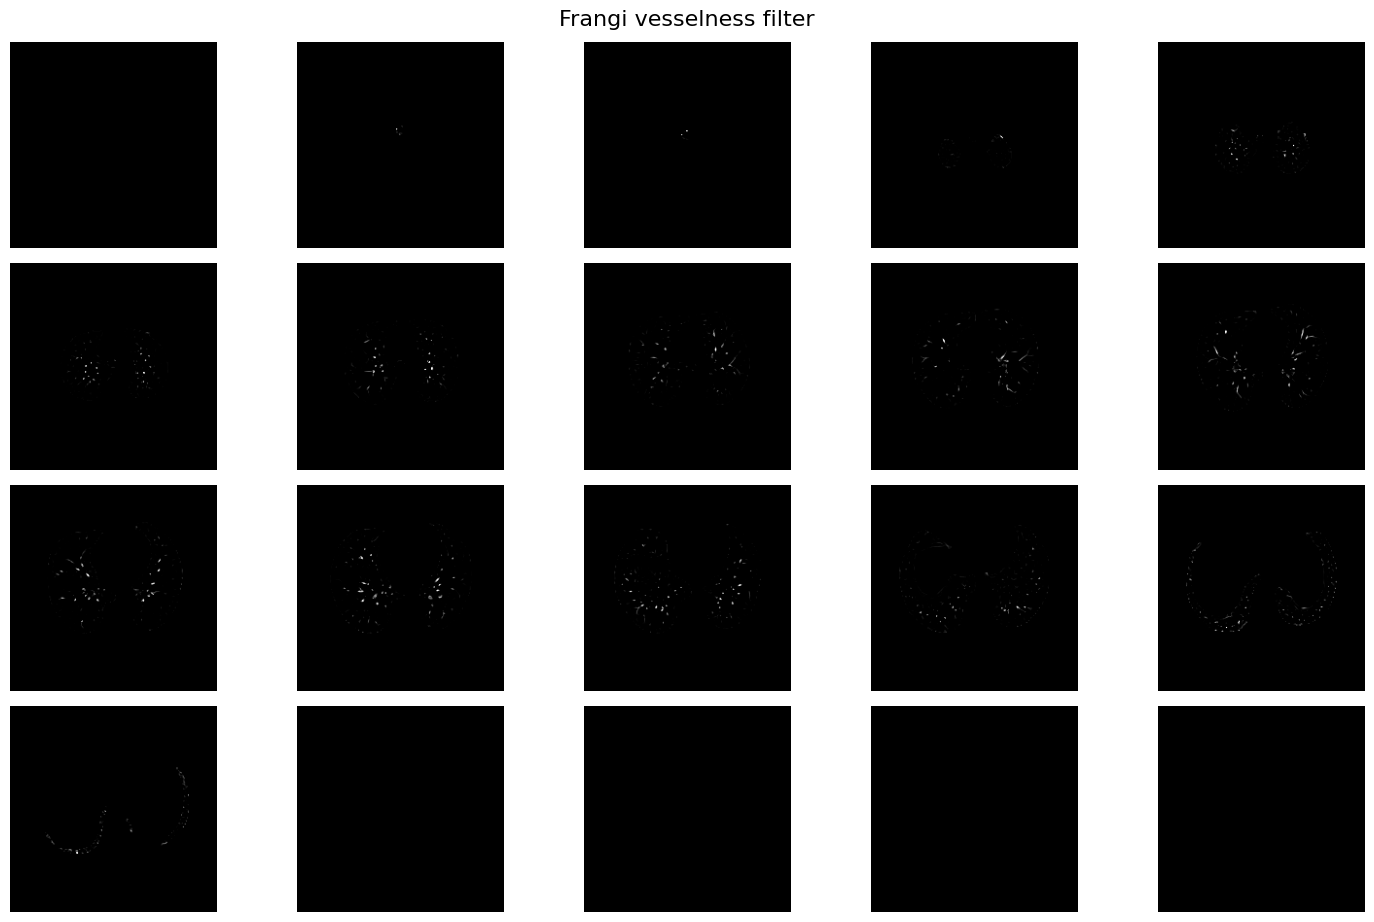

In [5]:
plot_slices(
    vol[0], max_images=20, n_columns=5, figsize=(15, 9), title="Original volume"
)


plot_slices(
    vessels[0], max_images=20, n_columns=5, figsize=(15, 9), title="Vessels mask"
)


plot_slices(
    process_image(frangi_seg, lungs[0]),
    max_images=20,
    n_columns=5,
    figsize=(15, 9),
    title="Frangi vesselness filter",
)

In [8]:
# metrics
from sklearn.metrics import roc_auc_score, roc_curve


def get_roc_auc(ground_truth_image, prediction_image, lung_mask):
    prediction = prediction_image[lung_mask == 1].flatten()
    ground_truth = ground_truth_image[lung_mask == 1].flatten()

    fpr, tpr, thresh = roc_curve(ground_truth, prediction)
    auc = roc_auc_score(ground_truth, prediction)

    return fpr, tpr, auc, thresh

## Frangi hyperparameters

100%|██████████| 11/11 [35:22<00:00, 192.98s/it]


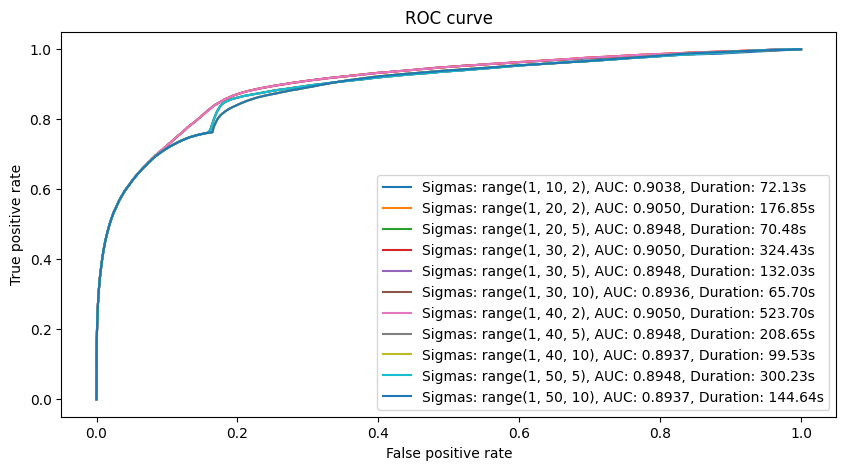

In [5]:
# Hyperparameters influence on frangi
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score
from time import time

sigmas_list = [
    range(1, 10, 2),
    range(1, 20, 2),
    range(1, 20, 5),
    range(1, 30, 2),
    range(1, 30, 5),
    range(1, 30, 10),
    range(1, 40, 2),
    range(1, 40, 5),
    range(1, 40, 10),
    range(1, 50, 5),
    range(1, 50, 10),
]

roc_curves = []

for sigmas in tqdm(sigmas_list):
    start = time()
    frangi_image = frangi(
        process_image(vol[0], lungs[0]),
        sigmas=sigmas,
        scale_range=None,
        scale_step=None,
        alpha=0.5,
        beta=0.5,
        gamma=None,
        black_ridges=False,
        mode="reflect",
        cval=0,
    )

    duration = time() - start

    fpr, tpr, auc, _ = get_roc_auc(vessels[0], frangi_image, lungs[0])

    roc_curves.append((fpr, tpr, auc, duration))

plt.figure(figsize=(10, 5))
for i, (fpr, tpr, auc, duration) in enumerate(roc_curves):
    plt.plot(
        fpr,
        tpr,
        label=f"Sigmas: {sigmas_list[i]}, AUC: {auc:.4f}, Duration: {duration:.2f}s",
    )

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.legend()
plt.show()

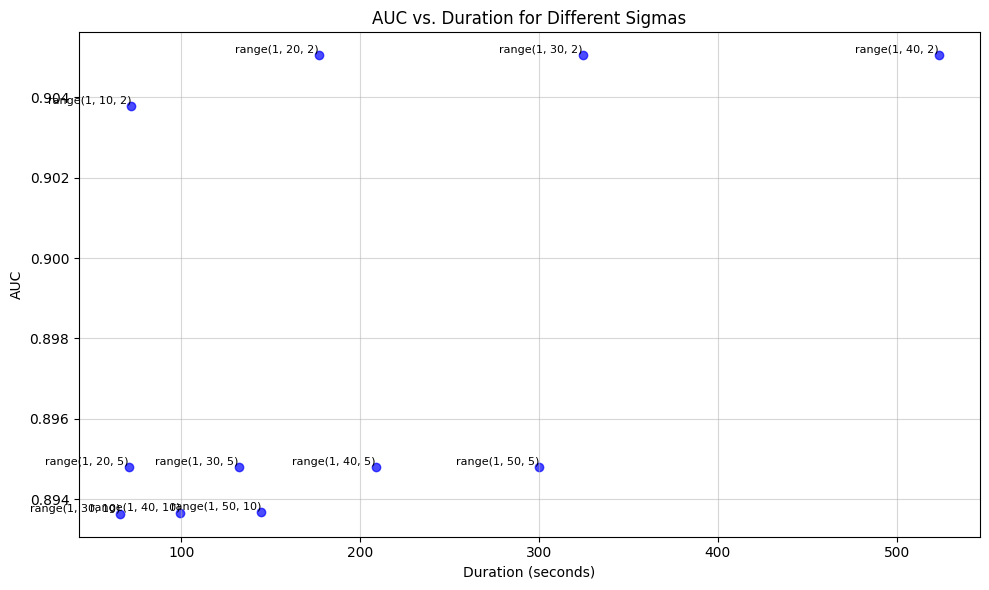

In [7]:
# plot AUC againt duration

import matplotlib.pyplot as plt

# Extract AUC, duration, and sigma ranges for labeling
auc_values = [item[2] for item in roc_curves]
durations = [item[3] for item in roc_curves]
sigma_labels = [str(sigmas) for sigmas in sigmas_list]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(durations, auc_values, color="blue", alpha=0.7)

# Annotate each point with the sigma range
for i, label in enumerate(sigma_labels):
    plt.text(durations[i], auc_values[i], label, fontsize=8, ha="right", va="bottom")

# Label the axes and add a title
plt.xlabel("Duration (seconds)")
plt.ylabel("AUC")
plt.title("AUC vs. Duration for Different Sigmas")
plt.grid(alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

## Test on a simple 2D image

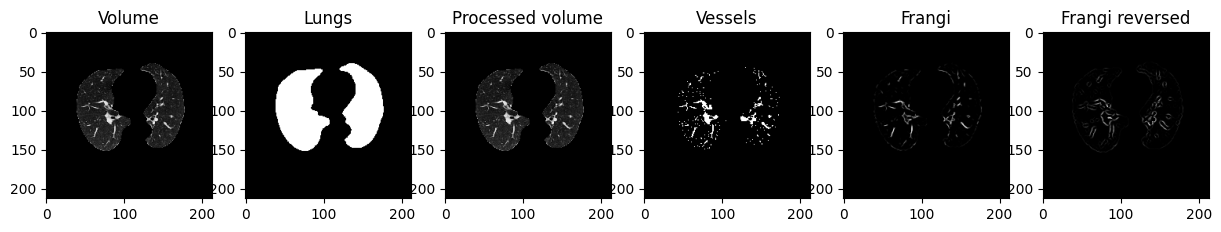

In [8]:
vol89 = vol[0][89]

vessels89 = vessels[0][89]

lungs89 = lungs[0][89]

frangi89 = frangi(
    process_image(vol89, lungs89),
    sigmas=range(1, 20, 2),
    scale_range=None,
    scale_step=None,
    alpha=0.5,
    beta=0.5,
    gamma=None,
    black_ridges=False,
    mode="reflect",
    cval=0,
)

frangi89_reversed = frangi(
    1 - process_image(vol89, lungs89),
    sigmas=range(1, 20, 2),
    scale_range=None,
    scale_step=None,
    alpha=0.5,
    beta=0.5,
    gamma=None,
    black_ridges=False,
    mode="reflect",
    cval=0,
)

plt.subplots(1, 6, figsize=(15, 9))
plt.subplot(161)
plt.imshow(vol89, cmap="gray")
plt.title("Volume")
plt.subplot(162)
plt.imshow(lungs89, cmap="gray")
plt.title("Lungs")
plt.subplot(163)
plt.imshow(process_image(vol89, lungs89), cmap="gray")
plt.title("Processed volume")
plt.subplot(164)
plt.imshow(vessels89, cmap="gray")
plt.title("Vessels")
plt.subplot(165)
plt.imshow(frangi89, cmap="gray")
plt.title("Frangi")
plt.subplot(166)
plt.imshow(frangi89_reversed, cmap="gray")
plt.title("Frangi reversed")
plt.show()

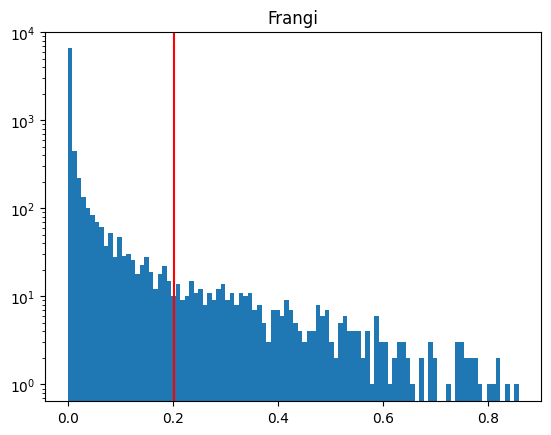

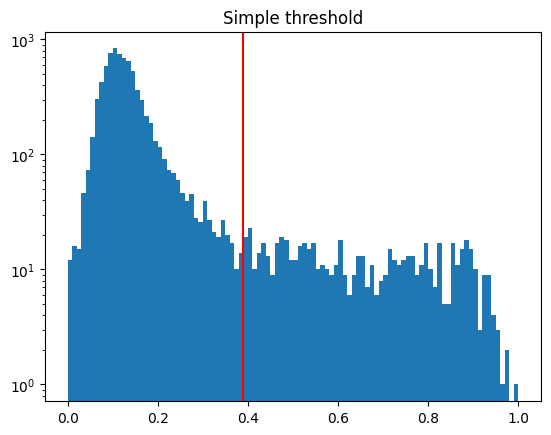

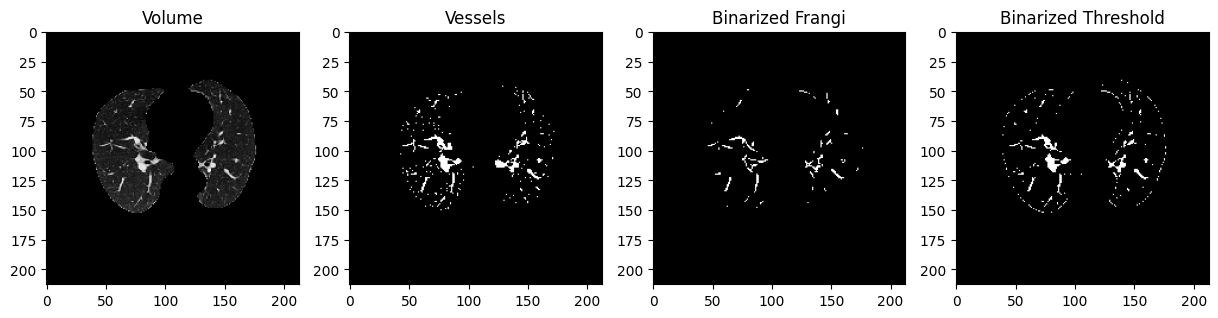

In [9]:
from skimage.filters import threshold_otsu


def binarize(image, lungs, show_plot=False, title=None):
    image = image.copy()

    lungs_pixels = image[lungs != 0]

    threshold = threshold_otsu(lungs_pixels)

    if show_plot:
        plt.hist(lungs_pixels, bins=100)
        plt.axvline(threshold, color="r")
        plt.yscale("log")
        if title:
            plt.title(title)
        plt.show()

    return image >= threshold


binary_frangi = binarize(frangi89, lungs89, show_plot=True, title="Frangi")

binary_threshold = binarize(
    process_image(vol89, lungs89), lungs89, show_plot=True, title="Simple threshold"
)

plt.subplots(1, 4, figsize=(15, 9))

plt.subplot(141)
plt.imshow(vol89, cmap="gray")
plt.title("Volume")
plt.subplot(142)
plt.imshow(vessels89, cmap="gray")
plt.title("Vessels")
plt.subplot(143)
plt.imshow(binary_frangi, cmap="gray")
plt.title("Binarized Frangi")
plt.subplot(144)
plt.imshow(binary_threshold, cmap="gray")
plt.title("Binarized Threshold")
plt.show()

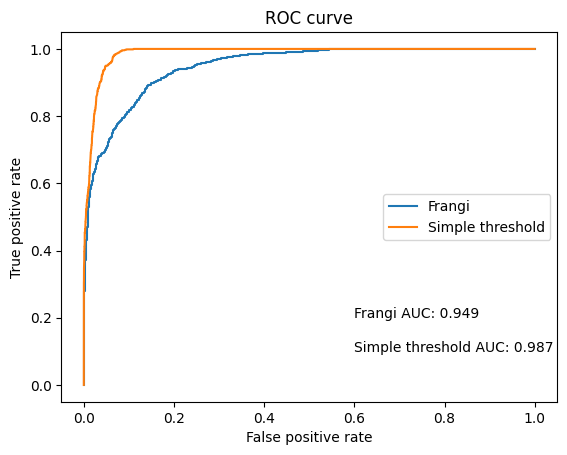

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_frangi, tpr_frangi, frangi_auc, _ = get_roc_auc(vessels89, frangi89, lungs89)

fpr_threshold, tpr_threshold, threshold_auc, _ = get_roc_auc(
    vessels89, process_image(vol89, lungs89), lungs89
)

plt.plot(fpr_frangi, tpr_frangi, label="Frangi")
plt.plot(fpr_threshold, tpr_threshold, label="Simple threshold")
plt.text(0.6, 0.2, f"Frangi AUC: {frangi_auc:.3f}")
plt.text(0.6, 0.1, f"Simple threshold AUC: {threshold_auc:.3f}")
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

## Test on 3D scans and comparison between Frangi and direct thresholding

In [6]:
# Compute all frangi vesselness images

import os
from tqdm import tqdm


def save_image(image, path):
    folder = os.path.dirname(path)
    if not os.path.exists(folder):
        os.makedirs(folder)

    image = sitk.GetImageFromArray(image)
    sitk.WriteImage(image, path)


for i in tqdm(range(len(vessels))):

    path = os.path.join(DATA_FOLDER, f"frangi_0{i}.nii.gz")
    if os.path.exists(path):
        continue

    frangi_image = frangi(
        process_image(vol[i], lungs[i]),
        sigmas=range(1, 20, 2),
        scale_range=None,
        scale_step=None,
        alpha=0.5,
        beta=0.5,
        gamma=None,
        black_ridges=False,
        mode="reflect",
        cval=0,
    )
    save_image(frangi_image, path)

100%|██████████| 6/6 [00:00<00:00, 5994.72it/s]


In [9]:
import os

frangi_vessels = [
    sitk.GetArrayFromImage(
        sitk.ReadImage(os.path.join(DATA_FOLDER, f"frangi_0{i}.nii.gz"))
    )
    for i in range(NUMBER_OF_ELEMENTS)
]


roc_curves_frangi = []

roc_curves_simple_threshold = []


for i in range(NUMBER_OF_ELEMENTS):

    roc_curves_frangi.append(get_roc_auc(vessels[i], frangi_vessels[i], lungs[i]))

    roc_curves_simple_threshold.append(
        get_roc_auc(vessels[i], process_image(vol[i], lungs[i]), lungs[i])
    )


global_vessels = np.concatenate([v.flatten() for v in vessels])


global_frangi_vessels = np.concatenate([f.flatten() for f in frangi_vessels])

global_lungs = np.concatenate([l.flatten() for l in lungs])

global_vol = np.concatenate([v.flatten() for v in vol])


global_frangi_roc = get_roc_auc(global_vessels, global_frangi_vessels, global_lungs)


global_threshold_roc = get_roc_auc(
    global_vessels, process_image(global_vol, global_lungs), global_lungs
)

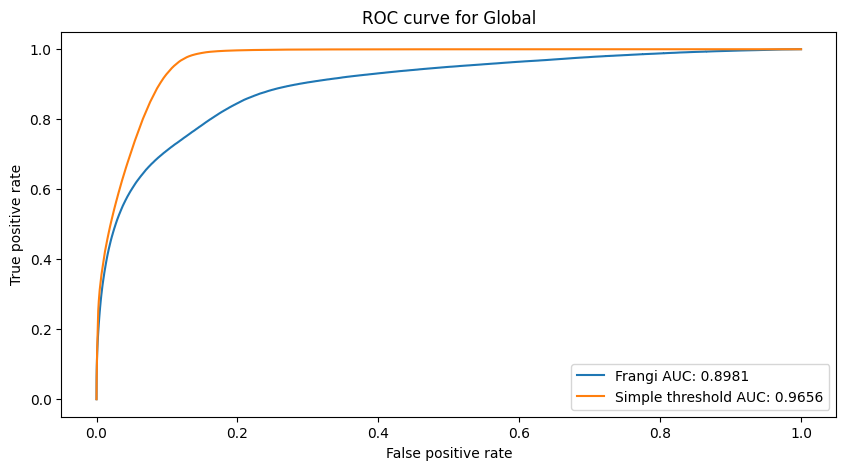

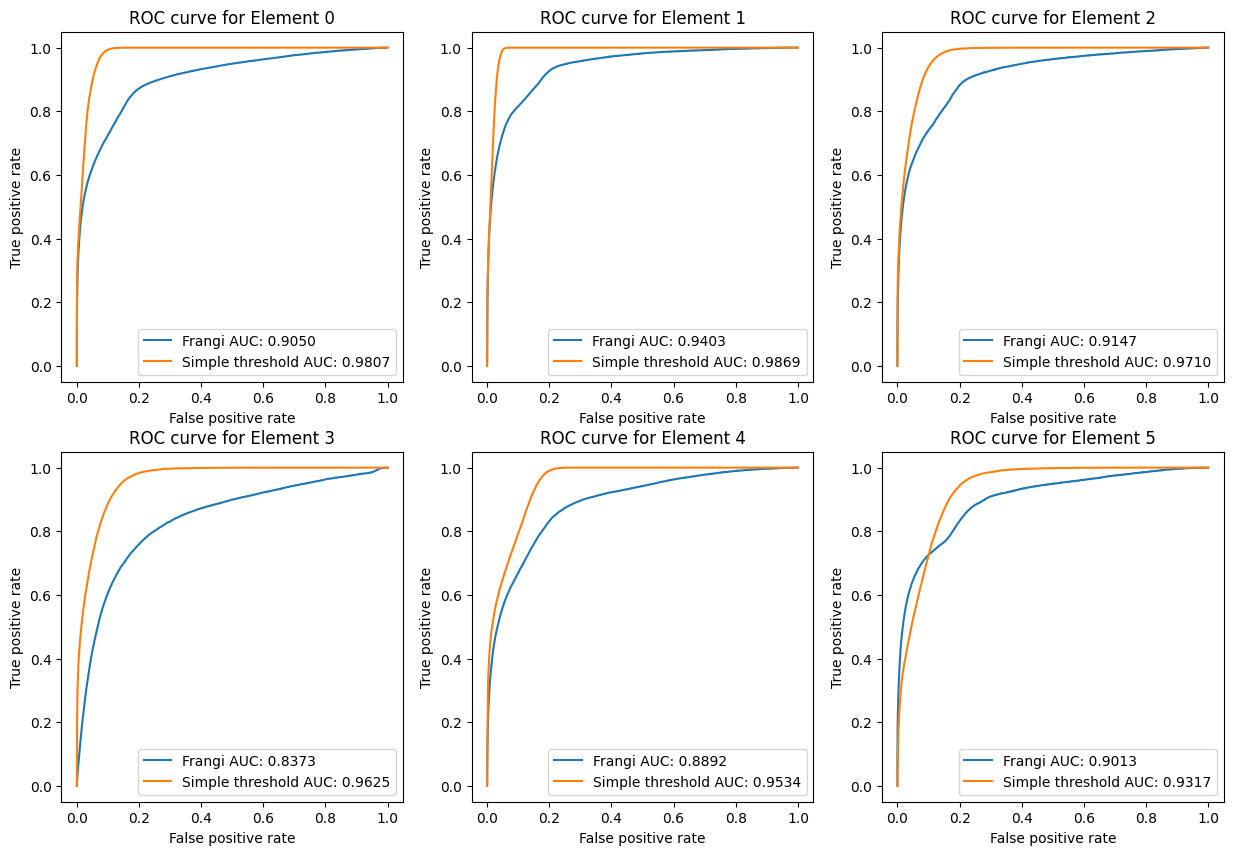

In [10]:
def plot_roc_comparison(frangi_roc, threshold_roc, data_name=None, show=False):
    plt.plot(frangi_roc[0], frangi_roc[1], label=f"Frangi AUC: {frangi_roc[2]:.4f}")
    plt.plot(
        threshold_roc[0],
        threshold_roc[1],
        label=f"Simple threshold AUC: {threshold_roc[2]:.4f}",
    )

    if data_name:
        plt.title(f"ROC curve for {data_name}")
    else:
        plt.title("ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()
    if show:
        plt.show()


plt.figure(figsize=(10, 5))

plot_roc_comparison(
    global_frangi_roc, global_threshold_roc, data_name="Global", show=True
)

plt.subplots(2, NUMBER_OF_ELEMENTS // 2, figsize=(15, 10))


for i in range(NUMBER_OF_ELEMENTS):
    plt.subplot(2, NUMBER_OF_ELEMENTS // 2, i + 1)
    plot_roc_comparison(
        roc_curves_frangi[i],
        roc_curves_simple_threshold[i],
        data_name=f"Element {i}",
        show=False,
    )

plt.show()

# Best threshold search

### Find best for vessel volume

In [12]:
from skimage.filters import threshold_otsu


def get_optimal_threshold_roc(roc_curve):
    fpr, tpr, _, thresholds = roc_curve

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold


def get_otsu_threshold(image, lungs_mask):
    image = image.copy()
    # only consider pixels inside the lungs, otsu is an algorithm that works on the histogram of the image
    lungs_pixels = image[lungs_mask != 0]

    threshold = threshold_otsu(lungs_pixels)

    return threshold


def get_optimal_threshold_for_volume(image, vessels_mask, lungs_mask):
    target = vessels_mask[lungs_mask != 0].sum()

    thresholds = np.linspace(0, 1, 100)
    best_threshold = None
    best_score = np.inf

    for threshold in thresholds:
        binary = image >= threshold
        score = np.abs(binary[lungs_mask != 0].sum() - target)

        if score < best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold


optimal_roc_frangi = []
optimal_otsu_frangi = []
optimal_volume_frangi = []

optimal_roc_threshold = []
optimal_otsu_threshold = []
optimal_volume_threshold = []

for i in range(NUMBER_OF_ELEMENTS):
    optimal_roc_frangi.append(get_optimal_threshold_roc(roc_curves_frangi[i]))
    optimal_otsu_frangi.append(get_otsu_threshold(frangi_vessels[i], lungs[i]))
    optimal_volume_frangi.append(
        get_optimal_threshold_for_volume(frangi_vessels[i], vessels[i], lungs[i])
    )

    optimal_roc_threshold.append(
        get_optimal_threshold_roc(roc_curves_simple_threshold[i])
    )
    optimal_otsu_threshold.append(
        get_otsu_threshold(process_image(vol[i], lungs[i]), lungs[i])
    )
    optimal_volume_threshold.append(
        get_optimal_threshold_for_volume(
            process_image(vol[i], lungs[i]), vessels[i], lungs[i]
        )
    )

optimal_roc_frangi_global = get_optimal_threshold_roc(global_frangi_roc)
optimal_otsu_frangi_global = get_otsu_threshold(global_frangi_vessels, global_lungs)
optimal_volume_frangi_global = get_optimal_threshold_for_volume(
    global_frangi_vessels, global_vessels, global_lungs
)

optimal_roc_threshold_global = get_optimal_threshold_roc(global_threshold_roc)
optimal_otsu_threshold_global = get_otsu_threshold(
    process_image(global_vol, global_lungs), global_lungs
)
optimal_volume_threshold_global = get_optimal_threshold_for_volume(
    process_image(global_vol, global_lungs), global_vessels, global_lungs
)

print("Optimal thresholds for Frangi:")
print("ROC curve:")
print(optimal_roc_frangi)
print(optimal_roc_frangi_global)
print("Otsu:")
print(optimal_otsu_frangi)
print(optimal_otsu_frangi_global)
print("Volume:")
print(optimal_volume_frangi)
print(optimal_volume_frangi_global)

print("Optimal thresholds for Simple threshold:")
print("ROC curve:")
print(optimal_roc_threshold)
print(optimal_roc_threshold_global)
print("Otsu:")
print(optimal_otsu_threshold)
print(optimal_otsu_threshold_global)
print("Volume:")
print(optimal_volume_threshold)
print(optimal_volume_threshold_global)

Optimal thresholds for Frangi:
ROC curve:
[np.float64(0.00014486791423387214), np.float64(0.00012680116413380158), np.float64(0.00021406065109203613), np.float64(0.0010806435823188733), np.float64(0.00014721356984306695), np.float64(0.00039471459682234567)]
0.00024125480426325763
Otsu:
[np.float64(0.12976356765223812), np.float64(0.11498009421368707), np.float64(0.11849847294651217), np.float64(0.05376438215113549), np.float64(0.069094399442125), np.float64(0.11952574816274367)]
0.10455747612927543
Volume:
[np.float64(0.010101010101010102), np.float64(0.030303030303030304), np.float64(0.020202020202020204), np.float64(0.04040404040404041), np.float64(0.020202020202020204), np.float64(0.04040404040404041)]
0.030303030303030304
Optimal thresholds for Simple threshold:
ROC curve:
[np.float64(0.1623578076525336), np.float64(0.15781167806417676), np.float64(0.1607324516785351), np.float64(0.43612903225806454), np.float64(0.12734375), np.float64(0.2024793388429752)]
0.3736049107142857
Otsu:


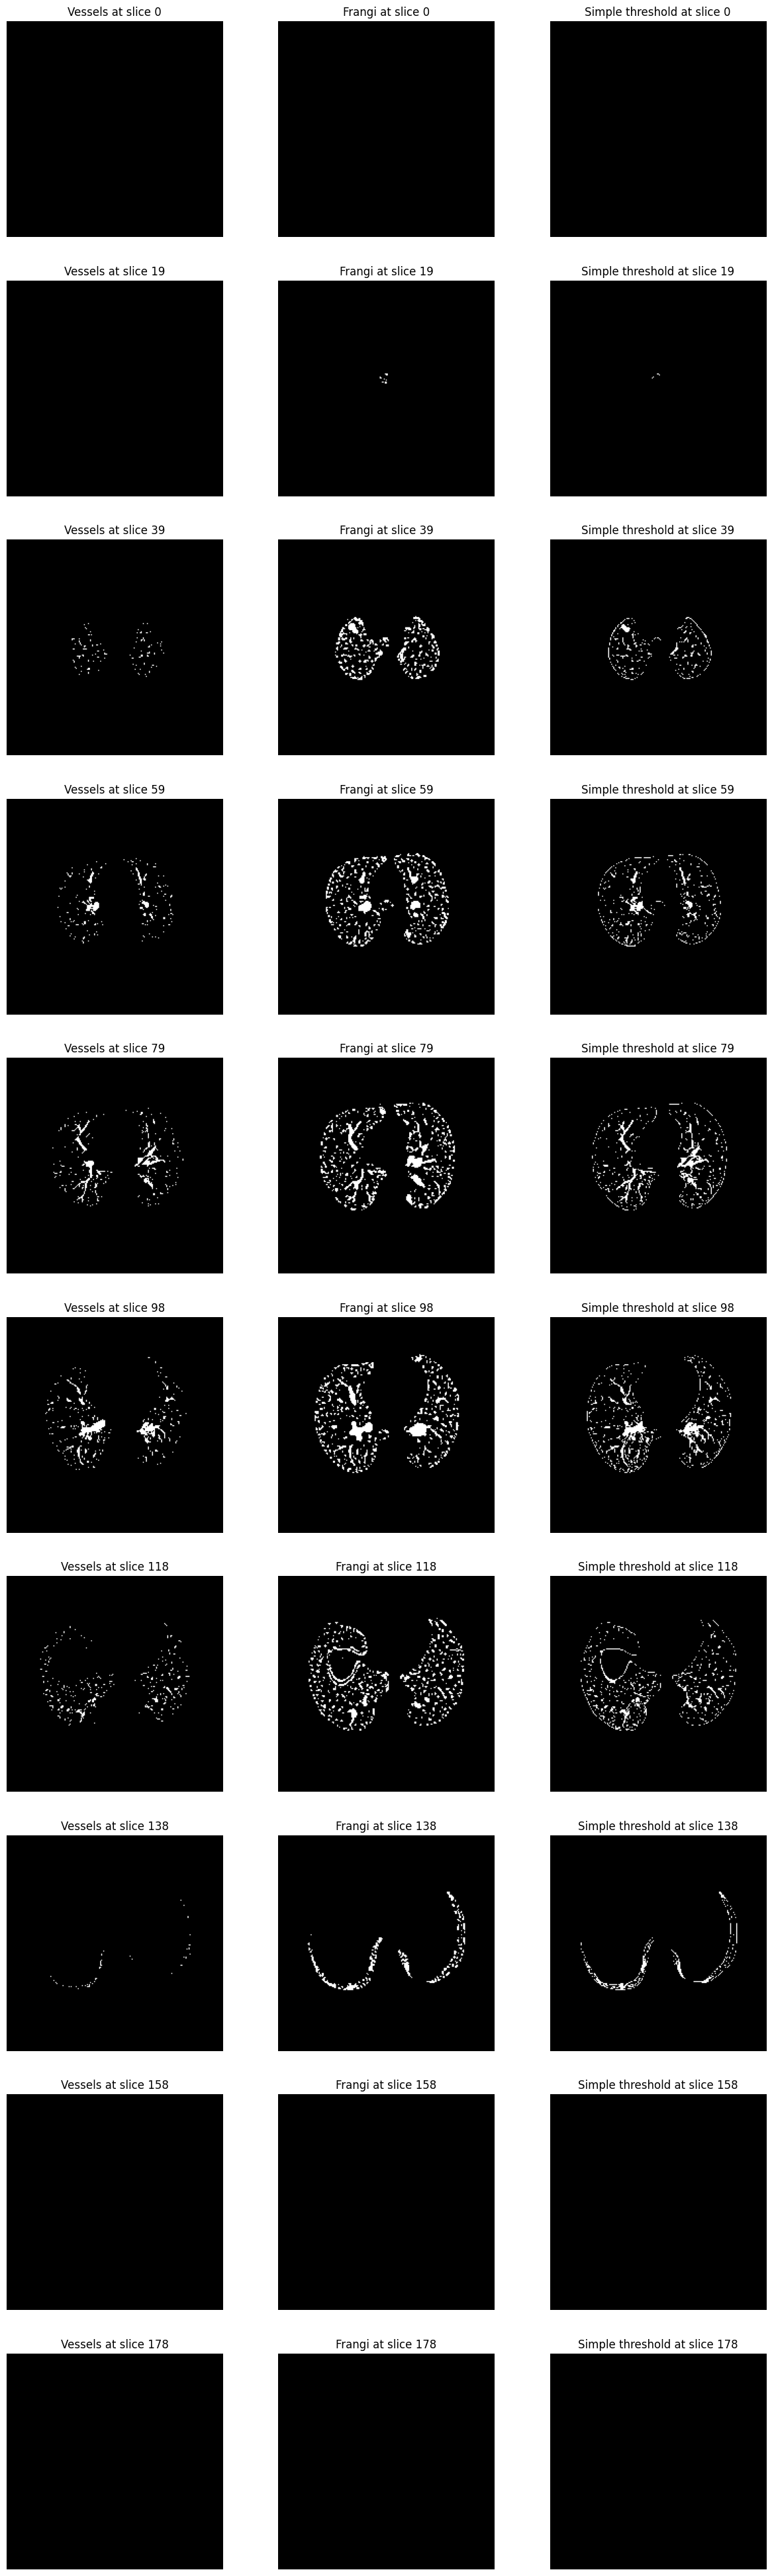

In [16]:
def plot_multiple_slices_horizontal(
    *tensors, max_images=5, labels=None, figsize=(5, 5)
):
    if labels is None:
        labels = [f"Tensor {i}" for i in range(len(tensors))]
    assert len(tensors) == len(labels)

    slices_indexes = np.linspace(0, tensors[0].shape[0] - 1, max_images).astype(int)

    fig, axes = plt.subplots(max_images, len(tensors), figsize=figsize)

    for i, slices_index in enumerate(slices_indexes):
        for j, tensor in enumerate(tensors):
            ax = axes[i, j]
            ax.imshow(tensor[slices_index], cmap="gray")
            ax.axis("off")
            ax.set_title(f"{labels[j]} at slice {slices_index}")

    # plt.tight_layout()
    plt.show()


index = 0

plot_multiple_slices_horizontal(
    # vol[index],
    vessels[index],
    frangi_vessels[index] >= optimal_roc_frangi[index],
    process_image(vol[index], lungs[index]) >= optimal_roc_threshold[index],
    labels=[
        # "Volume",
        "Vessels",
        "Frangi",
        "Simple threshold",
    ],
    max_images=10,
    figsize=(15, 50),
)

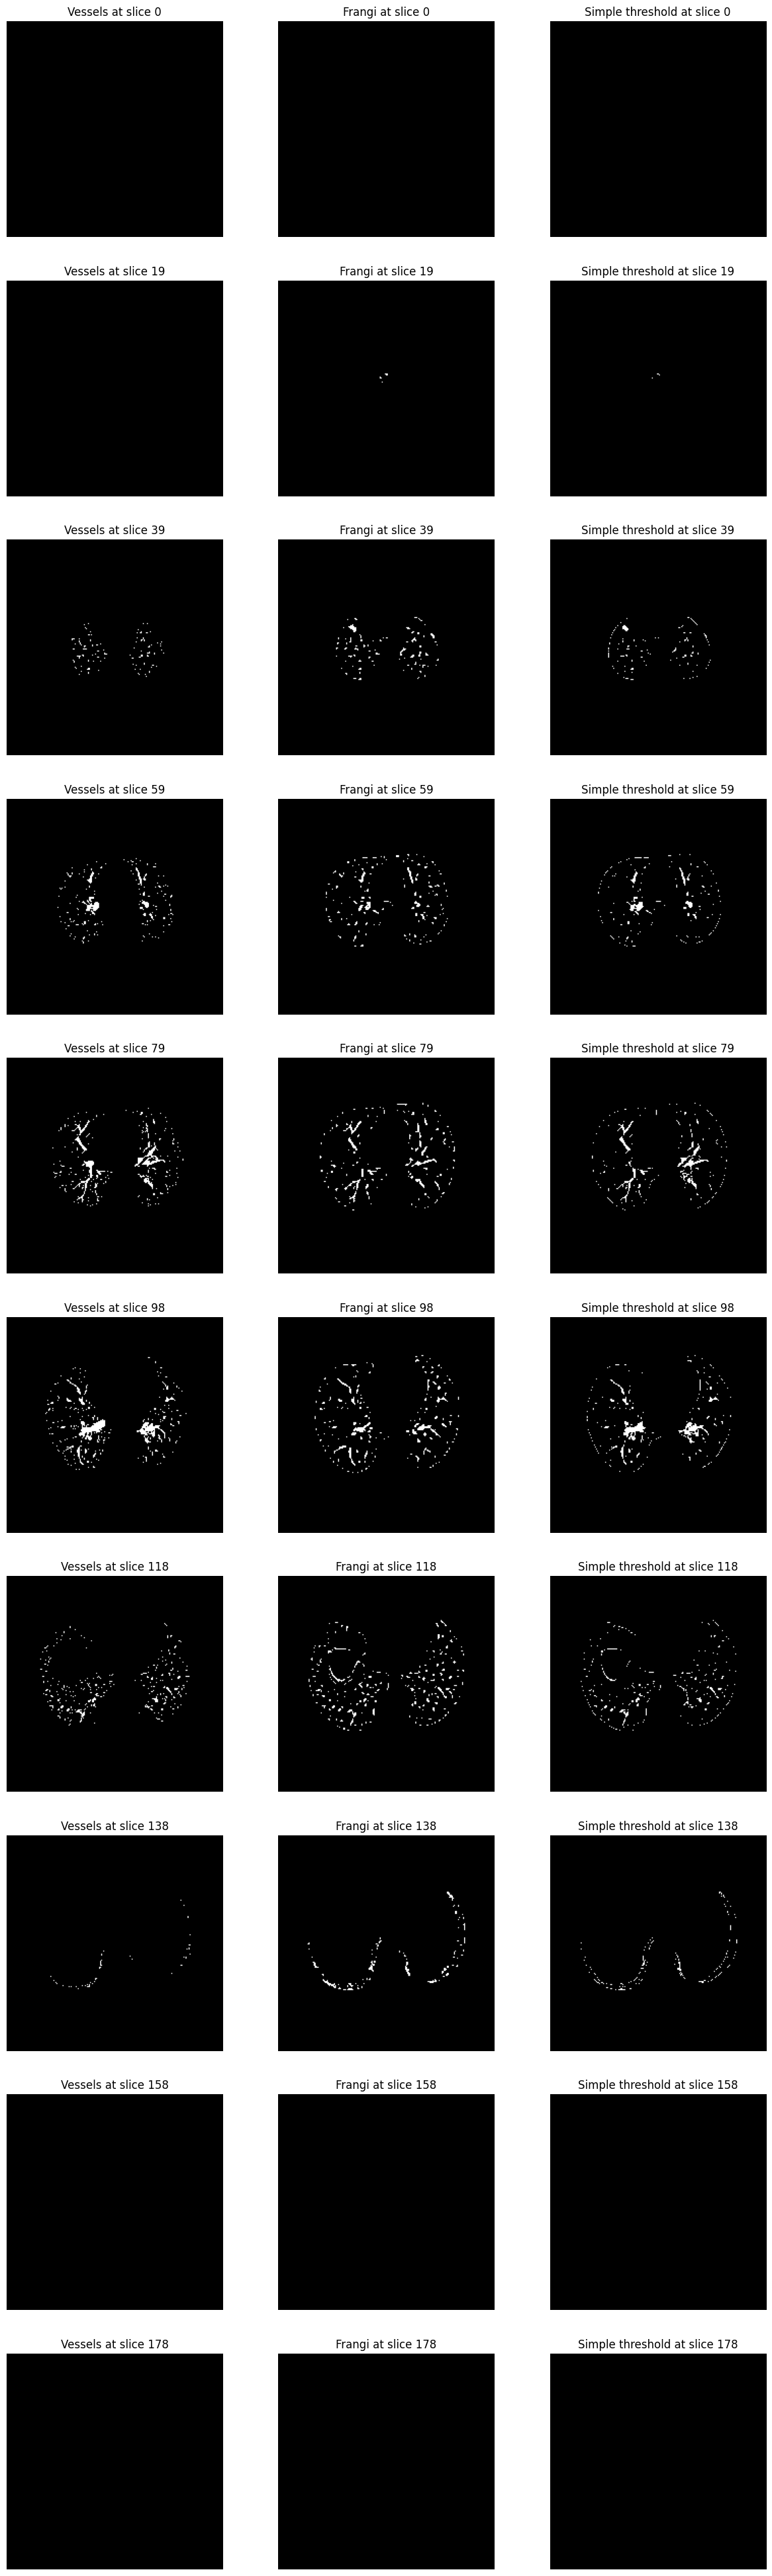

In [18]:
index = 0

plot_multiple_slices_horizontal(
    # vol[index],
    vessels[index],
    frangi_vessels[index] >= optimal_volume_frangi[index],
    process_image(vol[index], lungs[index]) >= optimal_volume_threshold[index],
    labels=[
        # "Volume",
        "Vessels",
        "Frangi",
        "Simple threshold",
    ],
    max_images=10,
    figsize=(15, 50),
)